
 <img src="" alt="add images here" width="100%"/>
 

# Analysis

In [286]:
# Import dependancies
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
from etherscan_py import etherscan_py

In [287]:
# Loading .env containing our keys
load_dotenv()

True

In [288]:
# create variable for api key 
api_key = os.getenv('COVALENT_API_KEY')
type(api_key)

str

## Current value of ETH

In [289]:
# import dependancy
from etherscan_py import etherscan_py
client = etherscan_py.Client(os.getenv('ETHERSCAN_API'))

# Print current eth price and latest block height
eth_value = client.get_eth_price()
eth_value

2725.21

## Set variables

In [290]:
# Append url for our api
url = "https://api.covalenthq.com/v1"
chain_id = "/1"
azuki_address = "/0xED5AF388653567Af2F388E6224dC7C4b3241C544"
cryptopunks_address = "/0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB"
BAYC_address = "/0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D"
date_option = '/?quote-currency=USD&format=JSON&from=2017-01-01&to=2022-05-01'
page_option = '/transactions_v2/?quote-currency=USD&format=JSON&block-signed-at-asc=false&no-logs=false&page-number=0&page-size=1000'
api_option = "&key=" + api_key
api_no_option = '/?key=' + api_key

## Concating all Owner metadata

In [291]:
# Append variable to url to get token owners
owner_url = url + chain_id + "/tokens" + azuki_address + "/nft_metadata" + '/' + '0' + api_no_option

# Get request
owner_data = requests.get(owner_url).json()

# Convert Owner json data to a dataframe and view data
owner_data_df = pd.DataFrame(owner_data['data']['items'][0]['nft_data'], columns = ['token_id', 'owner_address', 'burned'])

# Create empty dataframe for token_owner DataFrame
owner_columns = owner_data_df.columns

In [292]:
# Creating a new empty DataFrame to append all nft owner data rows into
token_owners = pd.DataFrame(columns = owner_columns)

# Show Token owner empty dataframes
token_owners

,token_id,owner_address,burned


In [293]:
# Loop through owner data and add into empty token_owners dataframe range = 100
for token_id in range(100):
    owner_url = url + chain_id + '/tokens' + azuki_address + '/nft_metadata/' + str(token_id) + api_no_option
    
    # Get Request and convert json to dataframe
    owner_data = requests.get(owner_url).json() 
    df = pd.DataFrame(owner_data['data']['items'][0]['nft_data'], columns = ['token_id', 'owner_address', 'burned'])
   
    token_owners.loc[token_id] = [df.iloc[0]['token_id'], df.iloc[0]['owner_address'], df.iloc[0]['burned']]

In [295]:
# Show token owner data
token_owners.head()

,token_id,owner_address,burned
0,0,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
1,1,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
2,2,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False
3,3,0x645d2b4bfb047566ff60e2e7112373885935eac4,False
4,4,0xd45058bf25bbd8f586124c479d384c8c708ce23a,False


## 1. Azuki Daily Volume

In [296]:
# Create variables needed for owner data and add to url
historical_url = url + chain_id + "/nft_market/collection" + azuki_address + api_no_option

# Get request
azuki_historical_json = requests.get(historical_url).json()

# Convert historical json data to a dataframe and view data
azuki_df = pd.DataFrame(azuki_historical_json['data']['items'])

# Set index to date
azuki_df = azuki_df.set_index('opening_date')

# Create Volume dataframe
azuki_vol_df = pd.DataFrame(azuki_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
azuki_vol_df

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2022-01-12,45941404.0,2402
2022-01-13,25129178.0,1318
2022-01-14,168151840.0,470
2022-01-15,4408686.0,499
2022-01-16,295638336.0,368
...,...,...
2022-04-02,24722180.0,193
2022-04-03,9899117.0,64
2022-04-04,4517060.5,40


<AxesSubplot:xlabel='opening_date'>

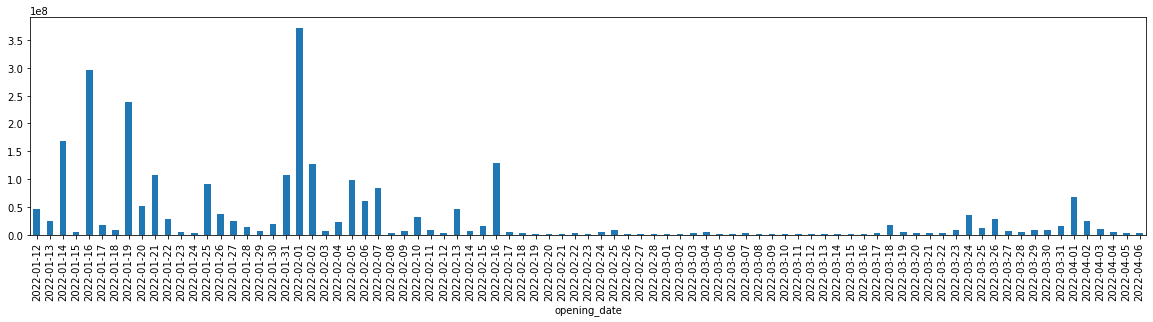

In [297]:
# Plot Volume quote per day
azuki_volume = azuki_vol_df['volume_quote_day'].astype(int)

azuki_volume.plot.bar(figsize = (20,4))

## 1. Azuki Historical transactions

In [298]:
# Quering the API for transaction data
azuki_tx_url = url + chain_id + "/address" + azuki_address + page_option + api_option 
azuki_tx = requests.get(azuki_tx_url).json()

# Convert transactions data to dataframe
azuki_tx_df = pd.DataFrame(azuki_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

azuki_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-05-02T07:38:33Z,None,3982607598190266,0.000000
2022-05-02T07:39:32Z,None,2350247375027552,0.000000
2022-05-02T07:41:52Z,None,1965230673585894,0.000000
2022-05-02T07:51:30Z,None,29852609435843082,19936.286091
2022-05-02T07:58:03Z,None,1788314720728250,0.000000


## 1.a Azuki Historical Sales

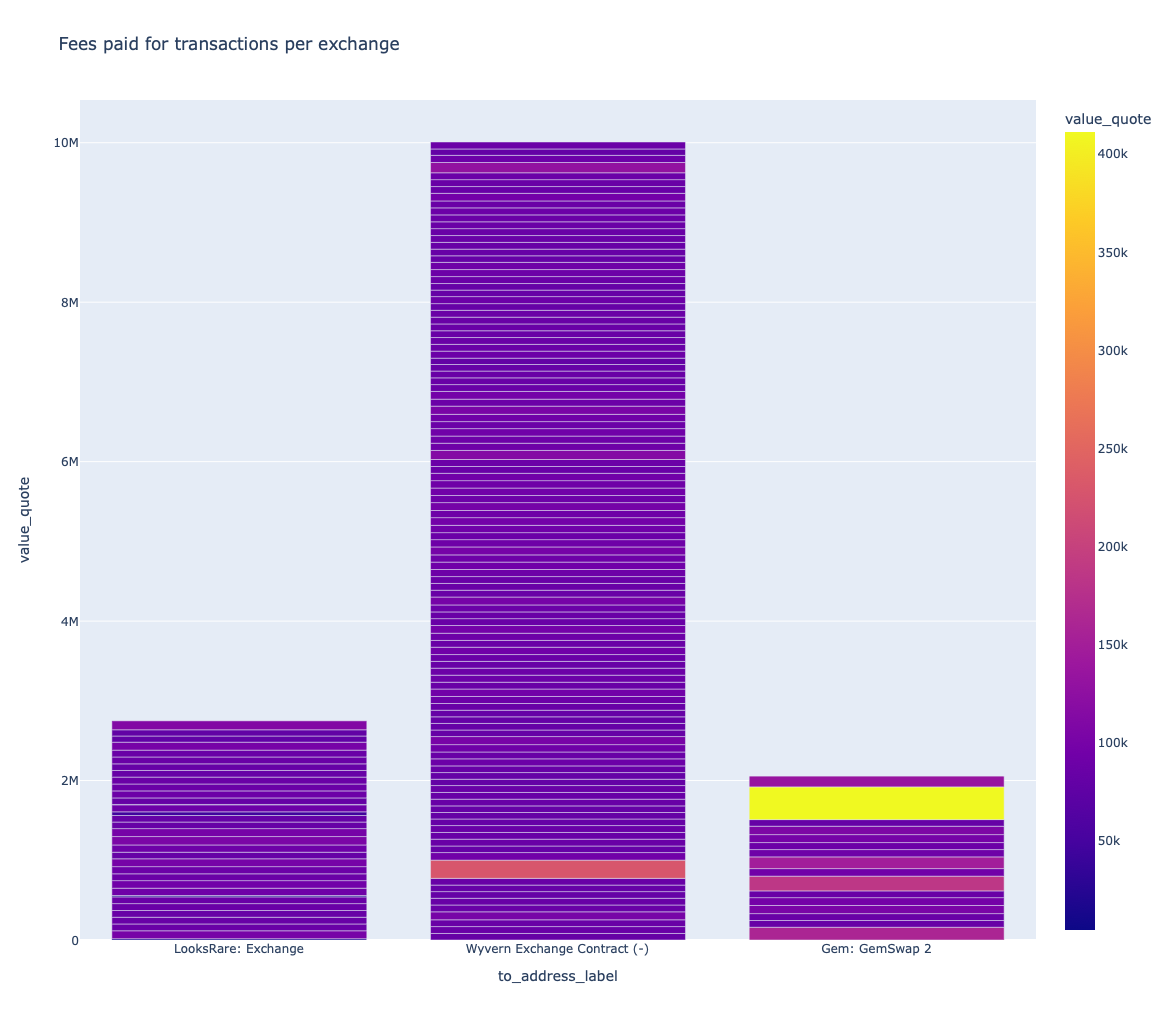

In [299]:
# Filter Through data for non null transactions
azuki_sales_df = azuki_tx_df[azuki_tx_df['value_quote'] != 0]
azuki_sales = azuki_sales_df[azuki_sales_df['to_address_label'].notnull()]

# Creating the plot using plotly express
azuki_fig = px.bar(azuki_sales, 
             x='to_address_label', 
             y= 'value_quote',
             color='value_quote',
             height=1020,
             width = 1000,
             title="Fees paid for transactions per exchange"
            )
azuki_fig.show()

## 1.b Azuki transaction fees paid

<AxesSubplot:xlabel='block_signed_at', ylabel='value in USD'>

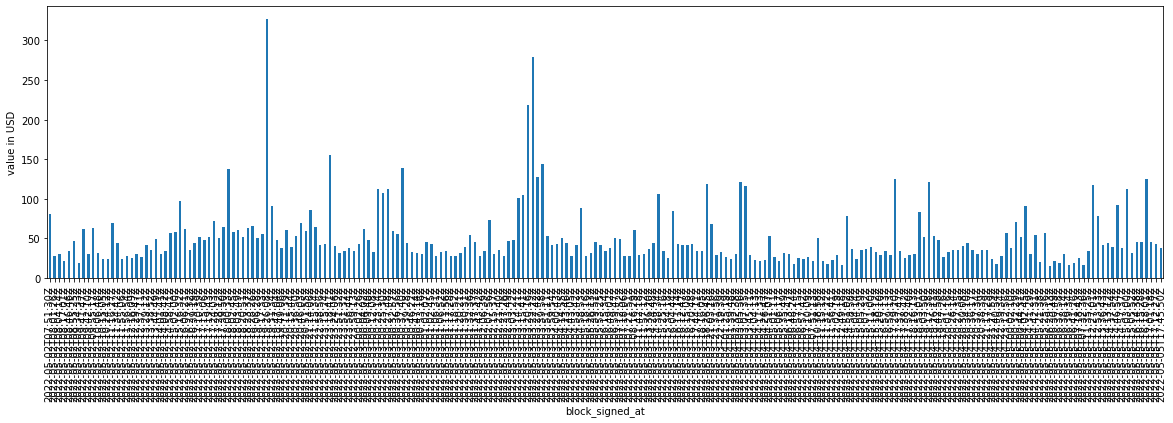

In [434]:
# Filter Through data for non null transactions
azuki_fees = azuki_sales_df['fees_paid'].astype(int)/10**18*eth_value

azuki_fees.plot.bar(rot = 90, figsize = (20,5), ylabel = 'value in USD')

## 2. Cryptopunks Daily Volume

In [301]:
# Create variables needed for owner data and append to url
cryptopunks_historical_url = url + chain_id + "/nft_market/collection" + cryptopunks_address + api_no_option

# Get request
cryptopunks_historical_json = requests.get(cryptopunks_historical_url).json()

# Convert historical json data to a dataframe and view data
cryptopunks_df = pd.DataFrame(cryptopunks_historical_json['data']['items'])

# Set index to date
cryptopunks_df = cryptopunks_df.set_index('opening_date')

# Create Volume dataframe
cryptopunks_vol_df = pd.DataFrame(cryptopunks_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
cryptopunks_vol_df.head()

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2017-06-23,0.0,19
2017-06-24,0.0,22
2017-06-25,0.0,11
2017-06-26,0.0,18
2017-06-27,0.0,35


<AxesSubplot:xlabel='opening_date'>

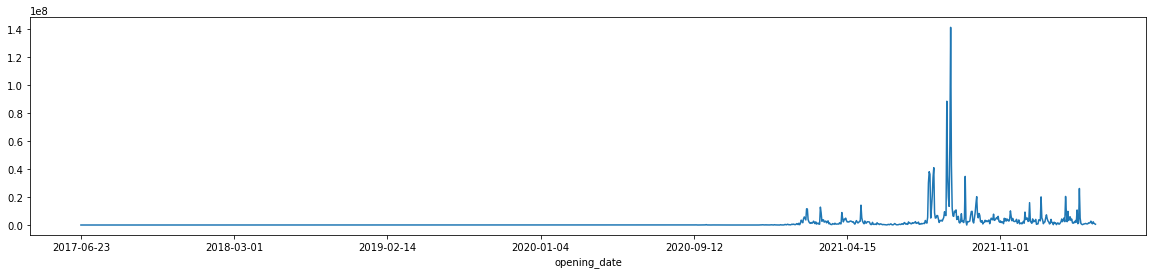

In [302]:
# Plot Volume quote per day
cryptopunks_volume = cryptopunks_vol_df['volume_quote_day'].astype(int)

cryptopunks_volume.plot.line(figsize = (20,4))

## 2a Cryptopunks Historical transactions

In [414]:
# Quering the API for transaction data
cryptopunks_tx_url = url + chain_id + "/address" + cryptopunks_address + page_option + api_option 
cryptopunks_tx = requests.get(cryptopunks_tx_url).json()

# Convert transactions data to dataframe
cryptopunks_tx_df = pd.DataFrame(cryptopunks_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

cryptopunks_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-04-27T16:29:53Z,CRYPTOPUNKS (Ͼ),1926936000000000,0.0
2022-04-27T16:29:53Z,CRYPTOPUNKS (Ͼ),1926936000000000,0.0
2022-04-27T16:30:01Z,CRYPTOPUNKS (Ͼ),1926936000000000,0.0
2022-04-27T16:37:38Z,CRYPTOPUNKS (Ͼ),3513052668631610,0.0
2022-04-27T16:38:49Z,CRYPTOPUNKS (Ͼ),2132300000000000,0.0


## 2.a Cryptopunks Historical Sales

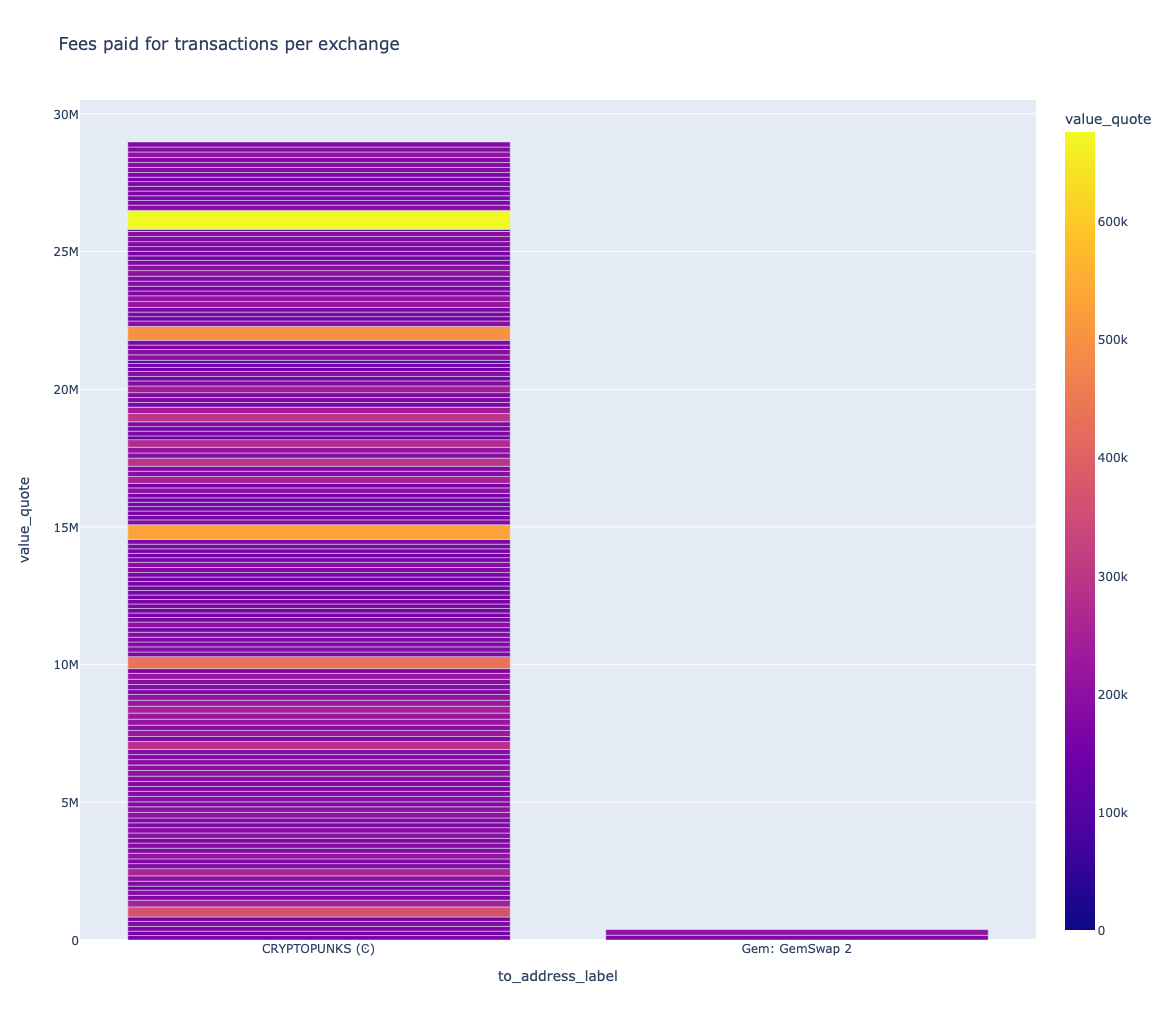

In [415]:
# Filter Through data for non null transactions
cryptopunks_sales_df = cryptopunks_tx_df[cryptopunks_tx_df['value_quote'] != 0]
cryptopunks_sales = cryptopunks_sales_df[cryptopunks_sales_df['to_address_label'].notnull()].dropna()


# Creating the plot using plotly express
cryptopunks_fig = px.bar(cryptopunks_sales, 
             x='to_address_label', 
             y= 'value_quote',
             color='value_quote',
             height=1020,
             width = 1000,
             title="Fees paid for transactions per exchange"
            )
cryptopunks_fig.show()

## 2.b Cryptopunks Fees paid

<AxesSubplot:xlabel='block_signed_at', ylabel='value in USD'>

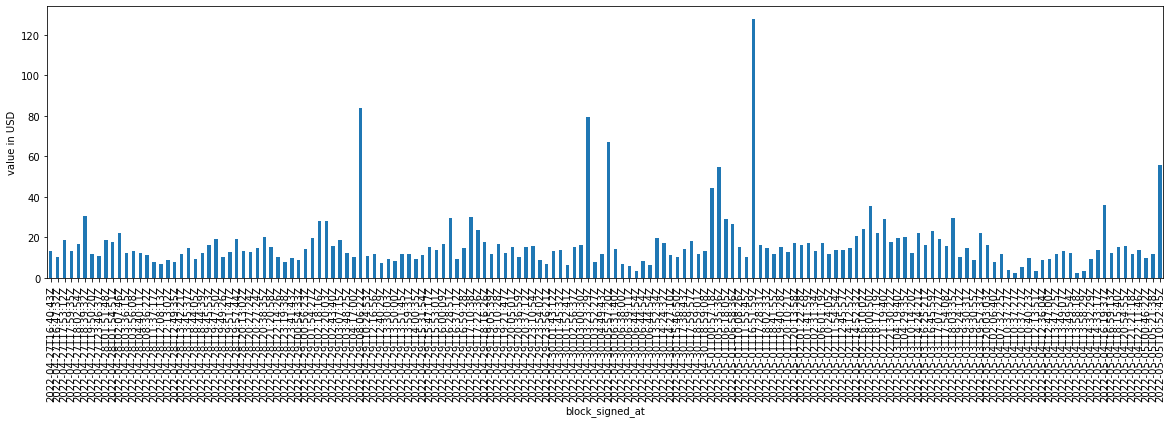

In [433]:
# Filter Through data for non null transactions
cryptopunks_fees = cryptopunks_sales_df['fees_paid'].astype(int)/10**18*eth_value

cryptopunks_fees.plot.bar(rot = 90, figsize = (20,5), ylabel = 'value in USD')

## 3. BAYC Daily Volume

In [306]:
# Create variables needed for owner data and add to url
BAYC_historical_url = url + chain_id + "/nft_market/collection" + BAYC_address + api_no_option

# Get request
BAYC_historical_json = requests.get(BAYC_historical_url).json()

# Convert historical json data to a dataframe and view data
BAYC_df = pd.DataFrame(BAYC_historical_json['data']['items'])

# Set index to date
BAYC_df = BAYC_df.set_index('opening_date')

# Create Volume dataframe
BAYC_vol_df = pd.DataFrame(BAYC_df, columns = ['volume_quote_day', 'unique_token_ids_sold_count_day']).sort_index()
BAYC_vol_df

,volume_quote_day,unique_token_ids_sold_count_day
opening_date,,
2021-04-30,8.241964e+02,1
2021-05-01,1.737182e+06,1635
2021-05-02,4.950946e+06,1534
2021-05-03,3.948996e+06,996
2021-05-04,1.388962e+06,336
...,...,...
2022-04-02,3.924610e+06,6
2022-04-03,3.946992e+06,10
2022-04-04,5.910691e+06,11


<AxesSubplot:xlabel='opening_date'>

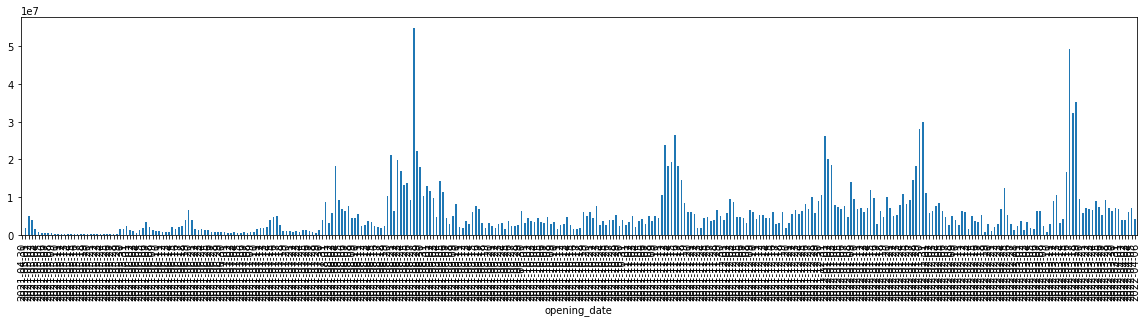

In [307]:
# Plot Volume quote per day
BAYC_volume = BAYC_vol_df['volume_quote_day'].astype(int)

BAYC_volume.plot.bar(figsize = (20,4))

## 3a BAYC Historical Sales

In [308]:
# Quering the API for transaction data
BAYC_tx_url = url + chain_id + "/address" + BAYC_address + page_option + api_option 
BAYC_tx = requests.get(BAYC_tx_url).json()

# Convert transactions data to dataframe
BAYC_tx_df = pd.DataFrame(BAYC_tx['data']['items'], columns = ['to_address_label','fees_paid', 'value_quote','block_signed_at']).set_index('block_signed_at').sort_index()

BAYC_tx_df.head()

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-05-02T15:35:30Z,None,3874808344457960,0.000000
2022-05-02T15:52:08Z,None,8513931761177811,0.000000
2022-05-02T15:55:23Z,Wyvern Exchange Contract (-),22855032989042062,371695.549316
2022-05-02T15:55:38Z,None,10679674840308063,0.000000
2022-05-02T15:56:25Z,LooksRare: Exchange,29860260602386347,0.000000


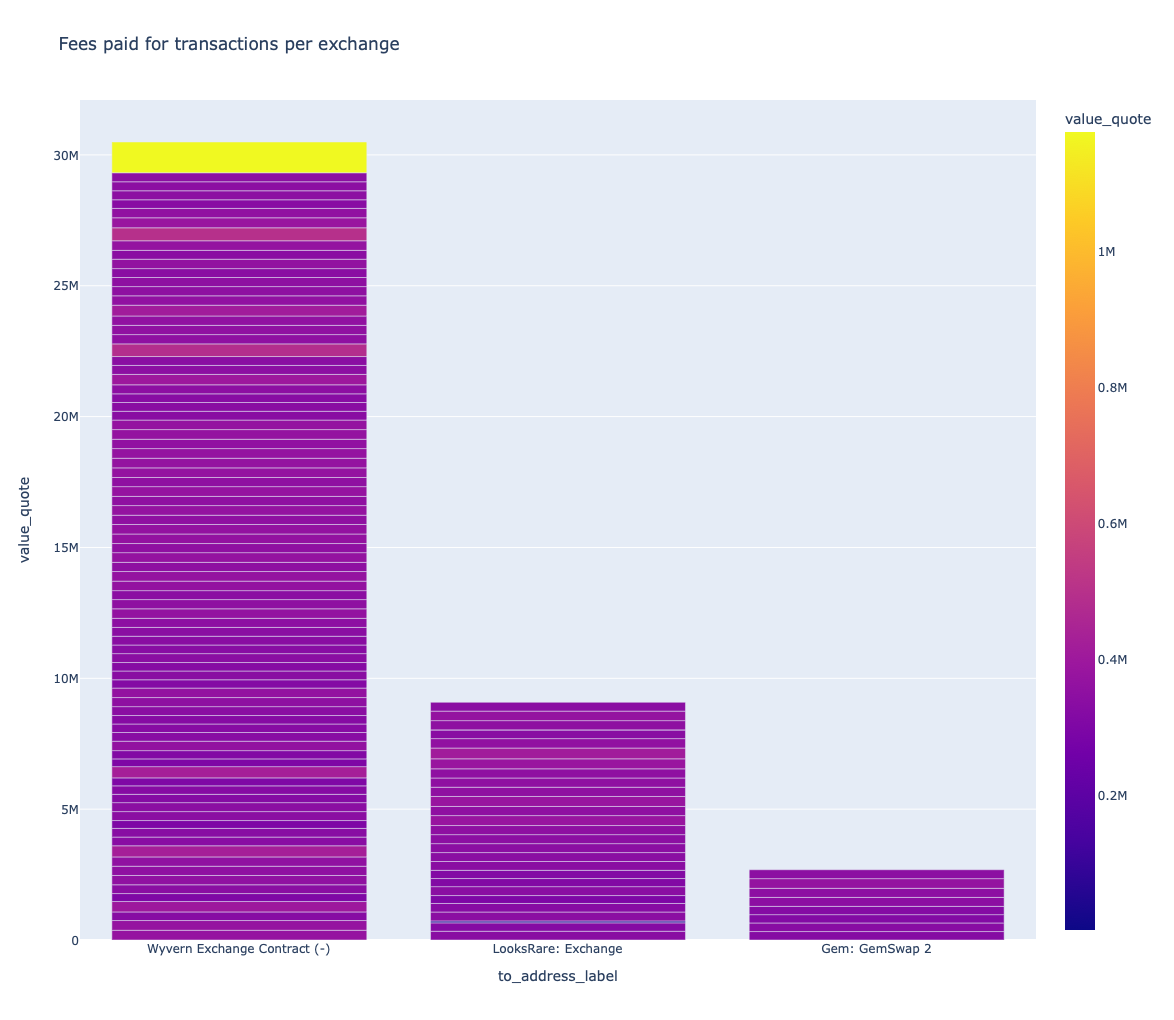

In [309]:
# Filter Through data for non null transactions
BAYC_sales_df = BAYC_tx_df[BAYC_tx_df['value_quote'] != 0]
BAYC_sales = BAYC_sales_df[BAYC_sales_df['to_address_label'].notnull()].dropna()

# Creating the plot using plotly express
BAYC_fig = px.bar(BAYC_sales, 
             x='to_address_label', 
             y= 'value_quote',
             color='value_quote',
             height=1020,
             width = 1000,
             title="Fees paid for transactions per exchange"
            )
BAYC_fig.show()

## 3.b BAYC Fees paid

<AxesSubplot:xlabel='block_signed_at', ylabel='value in USD'>

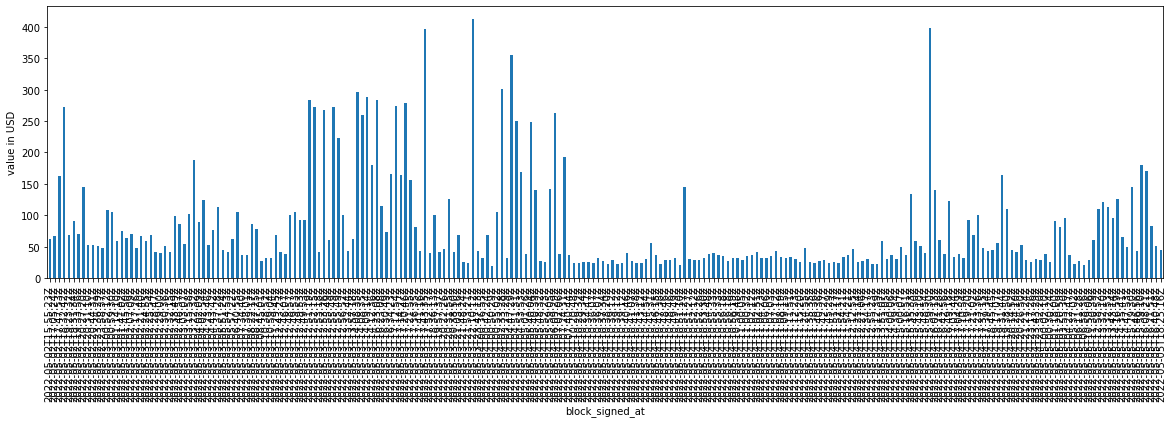

In [435]:
# Filter Through data for non null transactions
BAYC_fees = BAYC_sales_df['fees_paid'].astype(int)/10**18*eth_value

BAYC_fees.plot.bar(rot = 90, figsize = (20,5), ylabel = 'value in USD')

## Combine Total Sales

In [311]:
# Group by address label and sum the value
azuki_total = azuki_sales.groupby('to_address_label').sum()
cryptopunks_total = cryptopunks_sales.groupby('to_address_label').sum()
BAYC_total = BAYC_sales.groupby('to_address_label').sum()
BAYC_total

,value_quote
to_address_label,
Gem: GemSwap 2,2.684586e+06
LooksRare: Exchange,9.084090e+06
Wyvern Exchange Contract (-),3.049299e+07


In [312]:
# Combine and rename columns for our total sales data
combined_totals = pd.concat([azuki_total,cryptopunks_total,BAYC_total], axis=1)
combined_totals.columns = ['azuki_total', 'cryptopunks_total','BAYC_total']

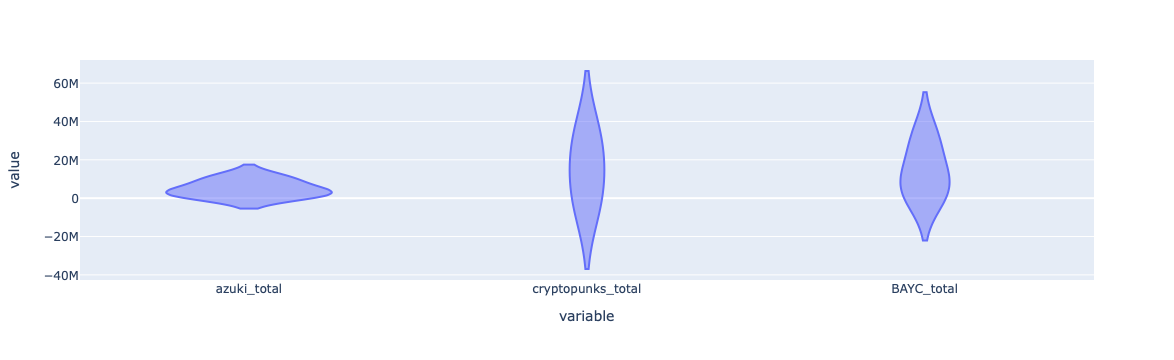

In [313]:
# Plot for combined figure
combined_total_fig = px.violin(combined_totals)

# Show Figure
combined_total_fig.show()

## Combine Total Fees

In [436]:
# Group by address label and sum the value
azuki_fees 
cryptopunks_fees 
BAYC_fees 

block_signed_at
2022-05-02T15:55:23Z     62.284764
2022-05-02T17:05:24Z     67.044152
2022-05-02T17:47:53Z    162.055074
2022-05-02T18:32:42Z    272.288948
2022-05-02T19:23:32Z     68.415750
                           ...    
2022-05-05T15:59:10Z    179.385890
2022-05-05T16:08:21Z    169.879546
2022-05-05T16:21:51Z     83.487560
2022-05-05T16:40:48Z     51.031801
2022-05-05T18:25:16Z     44.818762
Name: fees_paid, Length: 232, dtype: float64

In [439]:
# Group by address label and sum the value
BAYC_fees.mean()

80.27712120680344

In [366]:
azuki_sales['fees_paid'].astype(int)

block_signed_at
2022-05-02T08:01:26Z    10390866144852644
2022-05-02T08:04:14Z    10940432750903242
2022-05-02T08:17:01Z     7719700647634126
2022-05-02T08:46:46Z    12427390335546082
2022-05-02T09:34:33Z     6745013952058188
                              ...        
2022-05-05T15:05:52Z    11705463714643594
2022-05-05T16:14:38Z    16898067379883204
2022-05-05T17:01:18Z    16460595422925444
2022-05-05T17:12:27Z    15608053692469848
2022-05-05T17:45:50Z    14018773912125136
Name: fees_paid, Length: 162, dtype: int64

In [267]:
# Combine and rename columns for our total sales data
combined_fees = pd.concat([azuki_fees,cryptopunks_fees,BAYC_fees], axis=1)
combined_fees.columns = ['azuki_total', 'cryptopunks_total','BAYC_total']

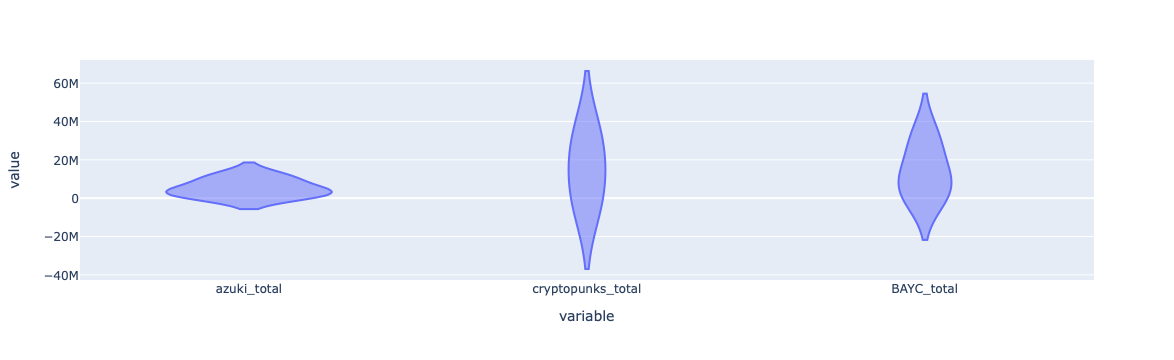

In [220]:
# Plot for combined figure
combined_fees_fig = px.violin(combined_totals)

# Show Figure
combined_fees_fig.show()

In [225]:
azuki_sales

,to_address_label,fees_paid,value_quote
block_signed_at,,,
2022-05-02T05:26:16Z,Wyvern Exchange Contract (-),9851883157320755,85489.976343
2022-05-02T05:36:24Z,Wyvern Exchange Contract (-),9069046172323845,81487.101196
2022-05-02T05:56:51Z,Wyvern Exchange Contract (-),10689576940401085,80057.502930
2022-05-02T06:14:23Z,Wyvern Exchange Contract (-),7901352473516036,157255.809326
2022-05-02T06:19:38Z,Gem: GemSwap 2,12414458871657650,77770.145703
...,...,...,...
2022-05-05T07:18:43Z,LooksRare: Exchange,9139240145431006,86009.860840
2022-05-05T07:32:36Z,LooksRare: Exchange,6107556000000000,99771.438574
2022-05-05T13:36:43Z,Wyvern Exchange Contract (-),15143566684658802,129014.791260


In [253]:
# azuki_sales.groupby('to_address_label').mean('fees_paid')
azuki_sales['fees_paid'].astype(int).sum()/10**18*eth_value

6858.121702734551